#  Constitutive Model Fitting

Constitutive models are used by people involved in computational mechancs (and potentially other fields) to simulate the behavior of materials under load. There are many types of models (linear, nonlinear, etc.) which vary in complexity from very simple to extremely complex. These models may be significantly expensive to run though great effort is placed upon solving the equations in an expedient fashion. Most generally, these equations are implemented as ordinary differential equations and solved using Newton-Raphson or some other technique.

It is of interest to fit constitutive equations to data collected in the laboratory and also to have an understanding of how much uncertainty there is in the parameters of the model. Bayesian approaches offer a potential solution for these problems.

## A Prony series viscoelastic model

A viscoelastic material is one in which the modulus of elasticity changes as a function of time. One common modeling approach is to use a collection of spring-damper pairs in parallel (a so-called general Maxwell model)

<img src="./images/maxwell_element.png" width=400>

In the figure $\mathcal{G}$ is a (in the general case) fourth order stiffness tensor, $\eta$ is the damping coefficient, ${E}$ is the applied strain (a second order tensor) and ${\xi}$ is the so-called backstrain in each Maxwell element (also a second order tensor). We can write the stress in one element as

\begin{align*}
\mathbb{G}^i_{IJKL} \left(E_{KL} - \xi^i_{KL}\right) &= \eta_i \dot{\xi}^i_{IJ}\\
\Rightarrow \dot{\xi}_{IJ}^i &= \frac{\mathbb{G}^i_{IJKL}}{\eta_i} \left(E_{KL} - \xi^i_{KL}\right)\\
\end{align*}

If we define $\tau^i = \frac{n_i}{G_{IJKL}}$ Noting that the tensorial nature becomes the identity tensor we can write the evolution equation for ${\xi}^i$ as

\begin{align*}
\dot{\xi}_{IJ}^i &= \frac{E_{KL} - \xi_{KL}^i}{\tau^i}
\end{align*}

We can solve for $\xi$ by using Newton-Raphson iteration (though for linear viscoelascity we can solve for this explicitly using some assumptions). The stress due to this element can be computed therefore via

\begin{align*}
S_{IJ} &= \mathbb{G}^{\infty}_{IJKL} E_{KL} + \sum_{i=1}^n \mathbb{G}_{IJKL}^i \left(E_{KL} - \xi_{KL}^i\right)\\
\end{align*}

Typically, when we use this in the development of a model for a general, 3D material, we break the deformation up into volume preserving (deviatoric) and volume changing (volumetric) stresses. A full stress tensor could be written in index notation (following Holzapfel) as

\begin{align*}
S_{IJ} &= K \det\left(E_{IJ}\right)^{\frac{1}{2}} C_{IJ}^{-1} + 2 J^{-\frac{2}{3}} \left[\mathbb{G}^{\infty}_{IJKL} \hat{E}_{KL} + \sum_{i=1}^n \mathbb{G}_{IJKL}^i \left(\hat{E}_{KL} - \xi_{KL}^i\right)\right]\\
\dot{\xi}_{IJ}^i &= \frac{\hat{E}_{KL} - \xi_{KL}^i}{\tau^i}\\
\hat{E}_{KL} &= E_{KL} - \frac{1}{3} E_{II} \delta_{KL}\\
E_{KL} &= \frac{1}{2} \left(C_{KL} - I_{KL}\right)\\
C_{KL} &= F_{IK} F_{IL}\\
\end{align*}

where $\hat{E}_{KL}$ is the traceless (deviatoric) part of $E$. These equations have been implemented below.

## Discription of problem

We will solve these equations with certain properties at a collection of rates. There will be noise applied to the parameters as well as to the resulting rates and the optimal parameters will be fit to these measures. We will assume that the stiffness tensors are isotropic (i.e. all $\mathbb{G}$s can be represented by scalars) and that the $\tau$ values are known. We define several utility functions for use in our calculations.

In [32]:
#Import required libraries
import numpy as np
import scipy.interpolate
import scipy.linalg
import unittest
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
#Define evolution equation of xi
def evolve_xins(dt, e, taus, statevars):
    """Evolve the backstrains"""
    
    for n in range(len(taus)):
        statevars[n*6:(n+1)*6] = evolve_xin(e, statevars[n*6:(n+1)*6], dt, taus[n])

In [34]:
def decompose_tensor(A):
    """Decompose a tensor into volumetric and deviatoric parts"""
    A_vol = np.trace(A)
    A_dev = A - A_vol*np.eye(3)/3.
    return A_dev,A_vol

def inflate_tensor(Aflat,is_symm=False):
    """Inflate a flattened 3x3 tensor to the matrix form
    
    is_symm: Indicates if the tensor is symmetric and so is stored in 
             6x1 form.
    """
    A = np.zeros([3,3])
    A[0,0] = Aflat[0]
    A[1,1] = Aflat[1]
    A[2,2] = Aflat[2]
    A[1,2] = Aflat[3]
    A[0,2] = Aflat[4]
    A[0,1] = Aflat[5]
    if(is_symm):
        A[2,1] = A[1,2]
        A[2,0] = A[0,2]
        A[1,0] = A[0,1]
    else:
        A[2,1] = Aflat[6]
        A[2,0] = Aflat[7]
        A[1,0] = Aflat[8]
    return A

def deflate_tensor(A,is_symm=False):
    """Deflate a 3x3 tensor to vector form
    
    is_symm: Indicates if the tensor is symmetric and should be stored in 
             6x1 form.
    """
    if(is_symm):
        Aflat = np.zeros([6,])
    else:
        Aflat = np.zeros([9,])
    Aflat[0] = A[0,0]
    Aflat[1] = A[1,1]
    Aflat[2] = A[2,2]
    Aflat[3] = A[1,2]
    Aflat[4] = A[0,2]
    Aflat[5] = A[0,1]
    if(not is_symm):
        Aflat[6] = A[2,1]
        Aflat[7] = A[2,0]
        Aflat[8] = A[1,0]
    return Aflat

In [35]:
def extract_params(params):
    """Extract the parameters"""
    K            = params[0]
    Ginf         = params[1]
    
    num_elements = (len(params)-2)/2
    #num_elements = int(params[2])
    
    taus = np.zeros([num_elements,])
    Gs   = np.zeros([num_elements,])
    
    for i in range(num_elements):
        
        Gs[i]   = params[2+i]
        taus[i] = params[2+i+num_elements]
        
    return K,Ginf,taus,Gs

In [36]:
def evolve_xin(e, xin, dt, taun, maxiter = 20, tol_abs = 1e-9, tol_rel = 1e-9):
    """Use Newton-Raphson to evolve the backstrain"""
    
    dxin   = np.zeros([6,])
    
    R     = dxin - dt*get_xidot(e,xin,taun)
    
    Rnorm = np.linalg.norm(R)
    
    Rnorm0 = Rnorm
    
    niter = 0
    
    while((np.abs(Rnorm)>tol_abs) and (np.abs(Rnorm/Rnorm0)>tol_rel) and niter<maxiter):
        J = 1. - dt*get_dxidotdxi(e,xin,taun)      #Compute the jacobian
        dxin = dxin - R/J                          #Update dxin
        R = dxin - dt*get_xidot(e,xin+dxin,taun)   #Compute the residual
        Rnorm = np.linalg.norm(R)                  #Update the norm
        niter += 1
        
    if((niter>=maxiter) and (np.abs(Rnorm)>tol_abs) and (np.abs(Rnorm/R0)>tol_rel)):
        print "Error: Convergence not achived in viscoelastic backstrain evolution"
        raise
    return xin+dxin

In [37]:
def get_xidot(en,xi,taun,get_tan=False):
    #Get the rate of change of xi
    
    if(get_tan):
        return (en-xi)/taun,-1./taun
    else:
        return (en-xi)/taun

def get_dxidotdxi(en,xi,taun):
    #Get the jacobian of xidot
    return -1./taun

In [38]:
def get_cauchy_green_deformation_tensor(Fflat):
    """Get the Cauchy-Green deformation tensor"""
    
    #Form the deformation gradient into a matrix form
    F = inflate_tensor(Fflat)
    
    #Compute the Cauchy-Green deformation tensor
    return np.dot(F.T,F)
    
def get_green_lagrange(C):
    """Compute the Green-Lagrange strain"""
    
    #Compute and return the Green-Lagrange strain
    return 0.5*(C - np.eye(3))
    
def get_stress(dt,F,params,statevars):
    """Compute the stress"""
    
    #Extract the parameters
    K,Ginf,taus,Gs = extract_params(params)
    
    #Set required values related to the deformation gradient
    F_matrix = inflate_tensor(F)
    J   = np.linalg.det(F_matrix)
    
    #Compute the Cauchy-Green deformation tensor
    C = get_cauchy_green_deformation_tensor(F)
    
    #Compute the Green-Lagrange strain
    E = get_green_lagrange(C)
    
    #Break into deviatoric and volumetric strain
    edev,evol = decompose_tensor(E)
    
    #Get a flat edev
    edev_flat = deflate_tensor(edev,is_symm=True)
    
    #Evolve the state variables
    evolve_xins(dt,edev_flat,taus,statevars)
    
    #Compute the PK2 stress
    S_vol = K*np.sqrt(np.linalg.det(E))*np.linalg.inv(C)#evol
    S_dev = 2*J**(-2./3)*(Ginf*edev_flat + sum([Gs[n]*(edev_flat-statevars[6*n:6*(n+1)]) for n in range(len(taus))]))
    
    #print S_vol
    #print S_dev
    #print sum(S_dev[:3])
    
    S     = deflate_tensor(S_vol,is_symm=True) + S_dev
    
    #print S
    
    #Map the PK2 stress to the current configuration
    PK2 = inflate_tensor(S,is_symm=True)
    #print PK2
    sigma = (1./J)*np.dot(F_matrix,np.dot(PK2,F_matrix.T))
    
    return deflate_tensor(sigma,is_symm=True)

In [39]:
def form_deformation_gradients(rate):
    """Form the target deformation gradients
    
    The deformation is comprised of a stretch and a rotation 
    (Polar decomposition).
    
    """
    
    times = [       0.,   1./rate,  10./rate]
    Us    = [np.eye(3), np.eye(3), np.eye(3)]
    Qs    = [np.eye(3), np.eye(3), np.eye(3)]
    
    Us[1][0,0] = 2.
    Us[2][0,0] = 2.
    
    Fs = [np.dot(Q,U) for U,Q in zip(Us,Qs)]
    
    Fmaxes = [np.zeros([9,]) for _ in range(len(Fs))]
    
    for i,F in enumerate(Fs):
        Fmaxes[i] = deflate_tensor(F)
        
    return times,Fmaxes

def apply_params_rate(rate,params,npts = 100):
    """Load up the material at a given rate with the given parameters
    
    to be used in parameter estimation"""
    
    #Form the deformation gradient
    #from the right stretch tensor U and 
    #the rotation tensor Q
    tmaxes,Fmaxes = form_deformation_gradients(rate)
    
    Iflat = np.zeros([9,])
    Iflat[0] = 1.
    Iflat[1] = 1.
    Iflat[2] = 1.
    
    statevars = np.hstack([np.zeros([6,]) for v in range(5)])
    
    ts     = np.hstack([np.linspace(tlb,tub,npts) for tlb,tub in zip(tmaxes[:-1],tmaxes[1:])])
    s      = np.zeros([6,len(ts)])
    strain = np.zeros([6,len(ts)])
    
    tp = 0.
    
    for i,t in enumerate(ts[1:]):
    
        dt = t - tp
        
        loc = [j for j,v in enumerate(tmaxes) if v>=t][0]
        
        den = tmaxes[loc]-tmaxes[loc-1]
        
        F = ((t-tmaxes[loc-1])/den)*(Fmaxes[loc]-Iflat) + (1. - (t-tmaxes[loc-1])/den)*(Fmaxes[loc-1]-Iflat) + Iflat
        
        #Compute the Green-Lagrange strain
        C = get_cauchy_green_deformation_tensor(F)
        E = get_green_lagrange(C)
        
        stress = get_stress(dt,F,params,statevars)
        s[:,i+1] = stress
        strain[:,i+1] = deflate_tensor(E,is_symm=True)[:]
    return ts,s,strain

We can demonstrate a viscoelastic response by using the parameters:

\begin{align*}
K &= 50\\
G_{\infty} &= 50\\
G &= \left[\begin{array}{ccc}
50 & 50 & 50\\
\end{array}\right]\\
\tau &= \left[\begin{array}{ccc}
1E-1 & 1E0 & 1E1\\
\end{array}\right]\\
\end{align*}

And letting the material stretch, without rotation, via
\begin{align*}
T &= \left[\begin{array}{ccc}
1 & 0 & 0\\
0 & 0 & 0\\
0 & 0 & 0\\
\end{array}\right]\\
t_p &= \frac{1}{r}\\
t_f &= \frac{5}{r}\\
F &= \begin{cases}
T \frac{t}{t_p} + I & \text{for } t\leq t_p\\
T + I & \text{for } t_p<t\leq t_f\\
\end{cases}
\end{align*}

where $r$ is the rate and $I$ is the 3x3 identity tensor. We will run four rates

\begin{align*}
r &= \left[\begin{array}{cccc}
1e-1 & 1e0 & 1e1 & 1e2\\
\end{array}\right]
\end{align*}

and then plot the 11 components of the stress tensor.

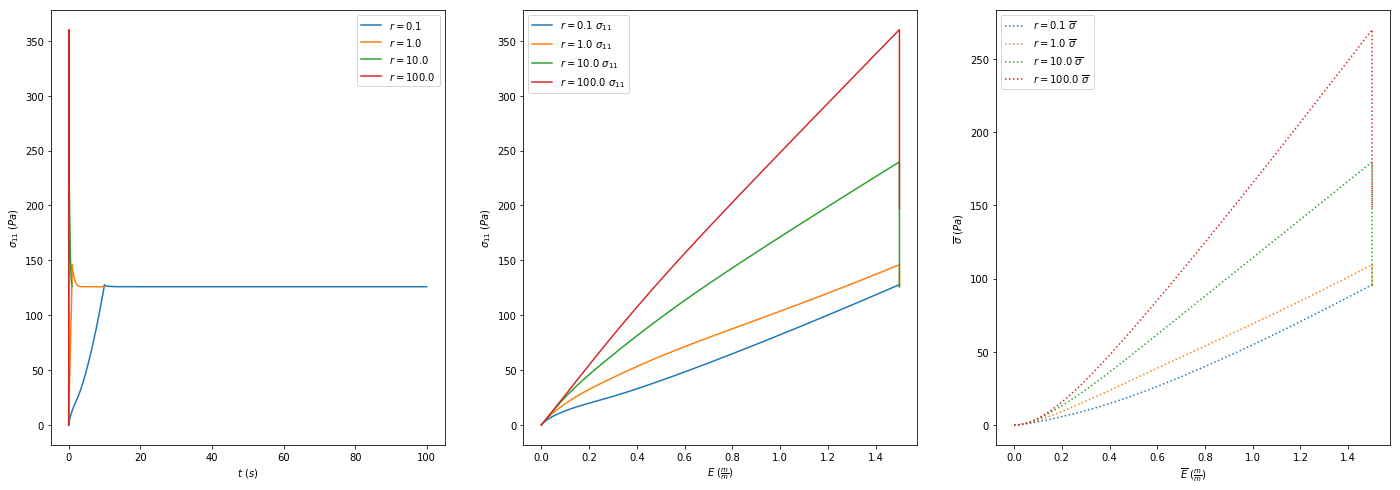

In [40]:
rates  = [1e-1, 1e0, 1e1, 1e2]
params = np.hstack([[50.,50.],[50., 50., 50.],[1e-1, 1e0, 1e1]])

time_storage   = np.zeros([len(rates),200])
stress_storage = np.zeros([len(rates),6,200])
strain_storage = np.zeros([len(rates),6,200])

plt.figure(figsize=[24,8])
plt.subplot(1,3,1)
plt.xlabel('$t\ (s)$')
plt.ylabel(r"$\sigma_{11}\ (Pa)$")

plt.subplot(1,3,2)
plt.xlabel(r'$E\ (\frac{m}{m})$')
plt.ylabel(r"$\sigma_{11}\ (Pa)$")

plt.subplot(1,3,3)
plt.xlabel(r'$\overline{E}\ (\frac{m}{m})$')
plt.ylabel(r"$\overline{\sigma}\ (Pa)$")

for i,rate in enumerate(rates):
    time_storage[i,:],stress_storage[i,:,:],strain_storage[i,:,:] = apply_params_rate(rate,params)
    
    plt.subplot(1,3,1)
    plt.plot(time_storage[i,:],stress_storage[i,0,:],'-',label=r"$r = {0}$".format(rate))
    
    plt.subplot(1,3,2)
    plt.plot(strain_storage[i,0,:],stress_storage[i,0,:],'-',label=r"$r = {0}$".format(rate)+"$\ \sigma_{11}$")
    
    plt.subplot(1,3,3)
    
    plt.plot([sum(strain_storage[i,:3,v]) for v in range(len(time_storage[i]))],\
             [sum(stress_storage[i,:3,v]) for v in range(len(time_storage[i]))],':',label=r"$r = {0}$".format(rate)+"$\ \overline{\sigma}$")

plt.subplot(1,3,1)
plt.legend()
plt.subplot(1,3,2)
plt.legend()
plt.subplot(1,3,3)
plt.legend()
plt.show()

So we can see that different strain rates will result in different stiffnesses of the material. More explicitly, high strain rates are stiffer than low strain rates.

### Simulated Laboratory Tests

These simulations are, effectively, perfect tests of a perfect material. In an actual experiment conducted in a laboratory we will have noise due to
- Material variability (uncertainty in the material parameters)
- Sensor error

If we apply normal noise to the output of 5 Pa, allow the moduli ($K$ $G_{\infty}$ and the $G$s) and the strain rate to vary by due to normally distributed noise with a standard deviation of 5%, and allow the measured strain to vary normally with a mean of zero and a standard deviation of 0.001 and then perform three experiments of each rate. The test will load at a constant rate and then hold the deformation for a length of time equal to ten times the inverse of the rate. This is the same loading path performed before.

In [41]:
#Set the random seed for repetability
np.random.seed(123)

def generate_random_test(test_rate,params):
    """Generate a test perturbed by random noise"""
    
    #Initialize the test parameters
    params_test = np.zeros([len(params),])
    
    #Extract the test parameters
    K,Ginf,taus,Gs = extract_params(params)
    
    #Sample the parameters for the test
    params_test[0] = K    + np.random.normal(0.,   K*0.01)
    params_test[1] = Ginf + np.random.normal(0.,Ginf*0.01)
    params_test[2:(2+len(Gs))] = [v + np.random.normal(0.,v*0.01) for v in Gs]
    params_test[(2+len(Gs)):]  = [v for v in taus]
    
    ts,stresses,strains = apply_params_rate(test_rate,params_test)
    
    stresses = np.array([[v + np.random.normal(0.,5.)    for v in stresses[w]] for w in range(6)])
    strains  = np.array([[v + np.random.normal(0.,0.001) for v in  strains[w]] for w in range(6)])
    
    return ts,stresses,strains

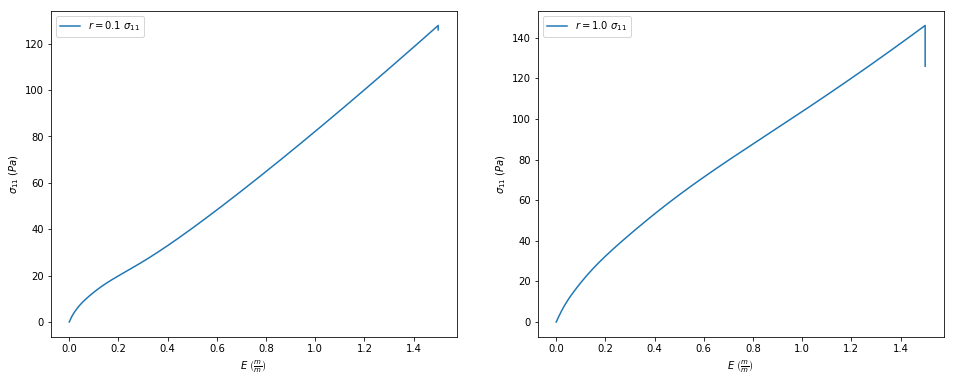

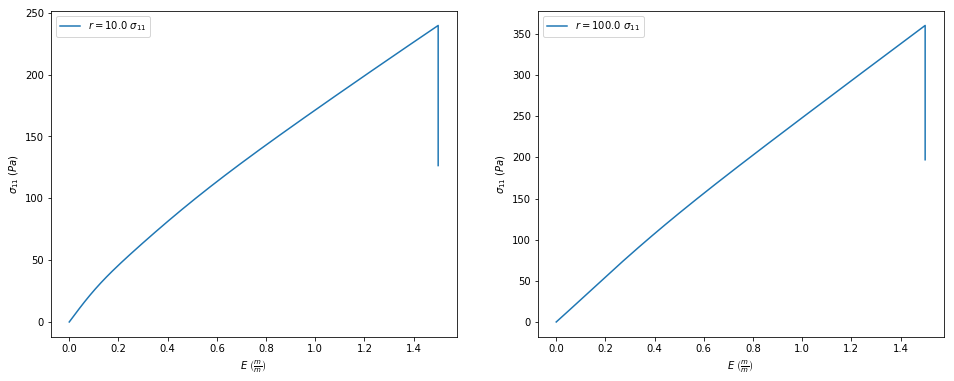

In [44]:
#Sample from the random tests

number_of_replicants = 3

test_time_storage   = np.zeros([len(rates),3,200])
test_stress_storage = np.zeros([len(rates),3,6,200])
test_strain_storage = np.zeros([len(rates),3,6,200])

nrows = len(rates)/2
row = 1
tmp = 1

for i,rate in enumerate(rates):

    plt.figure(row,figsize=[16,6])
    plt.subplot(1,2,tmp)
    tmp += 1
    if(tmp>2):
        tmp = 1
        row += 1
    
    plt.plot(strain_storage[i,0,:],stress_storage[i,0,:],'-',label=r"$r = {0}$".format(rate)+"$\ \sigma_{11}$")
    
    for replicant in range(number_of_replicants):
        test_rate = rate + np.random.normal(0.,0.05*rate)
        test_time_storage[i,replicant,:], test_stress_storage[i,replicant,:,:], test_strain_storage[i,replicant,:,:] =\
            generate_random_test(test_rate,params)
        #plt.plot(test_strain_storage[i,replicant,0,:],test_stress_storage[i,replicant,0,:],'o',label=r"$r = {0}$".format(rate)+"$\ \sigma_{11}$")
    plt.xlabel(r"$E\ \left(\frac{m}{m}\right)$")
    plt.ylabel(r"$\sigma_{11}\ (Pa)$")
    plt.legend()
plt.show()

### Estimating parameters

In order to estimate the parameters for a given experiment, we must define an error metric. For now, we can use a squared error normalized by the variance.

Often times, for actual experiments, we may only have the history of some measures (stress and strain are both computed from load-displacement data). In this case, we will assume that we have $\sigma_{11}$ and $E_{11}$ derived from the load-displacement data for each test. This will make it impossible to distinguish between the volumetric and deviatoric contributions of $K$ and $G_{\infty}$.

The organization of each dataset is:

data[rate, replicant, measure]

where each rate index corresponds to the values in the list: rates

The total data set is the applied conditions:

<table style="width:50%">
  <tr>
    <th>Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>test_time_storage</td>
    <td>Time measure</td>
  </tr>
  <tr>
    <td>E11s</td>
    <td>Strain in the 11 direction</td>
  </tr>
</table> 

and the measured response:
<table style="width:50%">
  <tr>
    <th>Name</th>
    <th>Description</th>
  </tr>
  <tr>
    <td>s11s</td>
    <td>Stress in the 11 direction</td>
  </tr>
</table> 

In [43]:
s11s          = np.array([[     test_stress_storage[r,rep,0,:]  for rep in range(number_of_replicants)] for r in range(len(rates))])
E11s          = np.array([[     test_strain_storage[r,rep,0,:]  for rep in range(number_of_replicants)] for r in range(len(rates))])